<a href="https://colab.research.google.com/github/milestbradley/instrument_classifier/blob/main/instrument_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from keras.utils import Sequence
from keras import Sequential
from keras import layers, Model
from keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, GlobalAveragePooling2D, Dense, Softmax, Conv1D, Add, Layer

Let's add layers to the model, inspired by the paper "CNN Architectures for Large-Scale Audio Classification" (<https://arxiv.org/abs/1609.09430>), particularly recreating the ResNet-18 architecture.

---



In [ ]:
class Convblock(Layer):
    def __init__(self):
        super(Convblock, self).__init__()
        self.conv = Conv2D(filters = 64, kernel_size = (7, 7), strides = (2, 2), padding = 'same')
        self.batchnorm = BatchNormalization()
        self.maxpool = MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'same')

    def call(self, inputs):
        x_skip = inputs

        x = self.conv(inputs)
        x = self.batchnorm(x)
        outputs = self.maxpool(x)

        return outputs
def make_convblock():
    conv_block = Sequential()
    conv_block.add(Convblock())
    return conv_block

class Resblock(Layer):
    def __init__(self, num_filters, match_dim = False):
        super(Resblock, self).__init__()
        self.strides = (2, 2) if match_dim else (1, 1)
        self.conv1 = Conv2D(filters = num_filters, kernel_size = (3, 3), strides = self.strides, padding = 'same')
        self.batchnorm1 = BatchNormalization()
        self.conv2 = Conv2D(filters = num_filters, kernel_size = (3, 3), strides = (1, 1), padding='same')
        if match_dim:
            self.down = Sequential()
            self.down.add(Conv2D(filters = num_filters, kernel_size = (1, 1), strides = self.strides))
            self.down.add(BatchNormalization())
        else:
            self.down = lambda x: x

    def call(self, inputs):
        x_skip = self.down(inputs)

        x = self.conv1(inputs)
        x = self.batchnorm1(x)
        x = self.conv2(x)
        x = self.batchnorm1(x)
        outputs = ReLU()(Add()([x_skip, x]))
        return outputs

def make_resblock(num_filters, match_dims = False):
    res_block = Sequential()
    res_block.add(Resblock(num_filters, match_dims))
    return res_block


def fullyconblock(x):
  x = GlobalAveragePooling2D()(x)
  x = Dense(units = 1, activation = 'sigmoid')(x)
  print(x.shape)
  return x

Now, let's put the blocks together to create our ResNet inspired model:

In [ ]:
class ResNet18(Model):
  def __init__(self):
    super(ResNet18, self).__init__()
    self.input_layer = Input(shape = (1024, 128, 1), dtype = 'float32')
    self.conv_block = make_convblock()
    self.res_block1 = make_resblock(num_filters = 64)
    self.res_block2 = make_resblock(num_filters = 64)
    self.res_block3 = make_resblock(num_filters = 128, match_dims = True)
    self.res_block4 = make_resblock(num_filters = 128)
    self.res_block5 = make_resblock(num_filters = 256, match_dims = True)
    self.res_block6 = make_resblock(num_filters = 256)
    self.res_block7 = make_resblock(num_filters = 512, match_dims = True)
    self.res_block8 = make_resblock(num_filters = 512)
    self.gap = GlobalAveragePooling2D()
    self.dense = Dense(units = 11, activation = 'softmax')

  def call(self, inputs):
    x = self.conv_block(inputs)
    x = self.res_block1(x)
    x = self.res_block2(x)
    x = self.res_block3(x)
    x = self.res_block4(x)
    x = self.res_block5(x)
    x = self.res_block6(x)
    x = self.res_block7(x)
    x = self.res_block8(x)
    x = self.gap(x)
    outputs = self.dense(x)

    return outputs


In [ ]:
import os
import h5py
import numpy as np
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random

Let's build a dataloader and load in our mel_spectrograms before training our model!

In [ ]:
folders = os.listdir('/content/drive/MyDrive/Audio_Project/ARMAS_Spectrogams')
print(folders)

i = 0
data = []
labels = []
for folder in folders:
   path = os.path.join('/content/drive/MyDrive/Audio_Project/ARMAS_Spectrogams', folder)
   data = data + [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.h5')]
   labels = labels + [i] * len(data)
   i += 1
labels = to_categorical(labels, num_classes = 11)
dataset = list(zip(data, labels))
random.shuffle(dataset)
data, labels = zip(*dataset)

val_size = int(len(data)*.15)
val_data = data[:val_size]
val_labels = labels[:val_size]
train_data = data[val_size:]
train_labels = labels[val_size:]

['cel', 'cla', 'flu', 'gac', 'gel', 'org', 'pia', 'sax', 'tru', 'vio', 'voi']


In [ ]:
class H5DataGenerator(Sequence):
    def __init__(self, file_list, labels, batch_size=256, max_length = 256, shuffle=True):
        self.file_list = file_list
        self.labels = labels
        self.batch_size = batch_size
        self.max_length = max_length
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.file_list) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.file_list[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_files, batch_labels)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            combined = list(zip(self.file_list, self.labels))
            random.shuffle(combined)
            self.file_list, self.labels = zip(*combined)

    def __data_generation(self, batch_files, batch_labels):
        batch_data = []

        for file in batch_files:
            with h5py.File(file, 'r') as hf:
                data = np.array(hf['tensor'])
                batch_data.append(data)
        batch_data_padded = pad_sequences(batch_data, maxlen = self.max_length, padding = 'post', dtype = 'float32')
        batch_data_padded = np.expand_dims(batch_data_padded, -1)
        return np.array(batch_data_padded), np.array(batch_labels)

train_generator = H5DataGenerator(train_data, train_labels, batch_size = 256)
val_generator = H5DataGenerator(val_data, val_labels, batch_size = 256)


(256, 256, 128, 1)


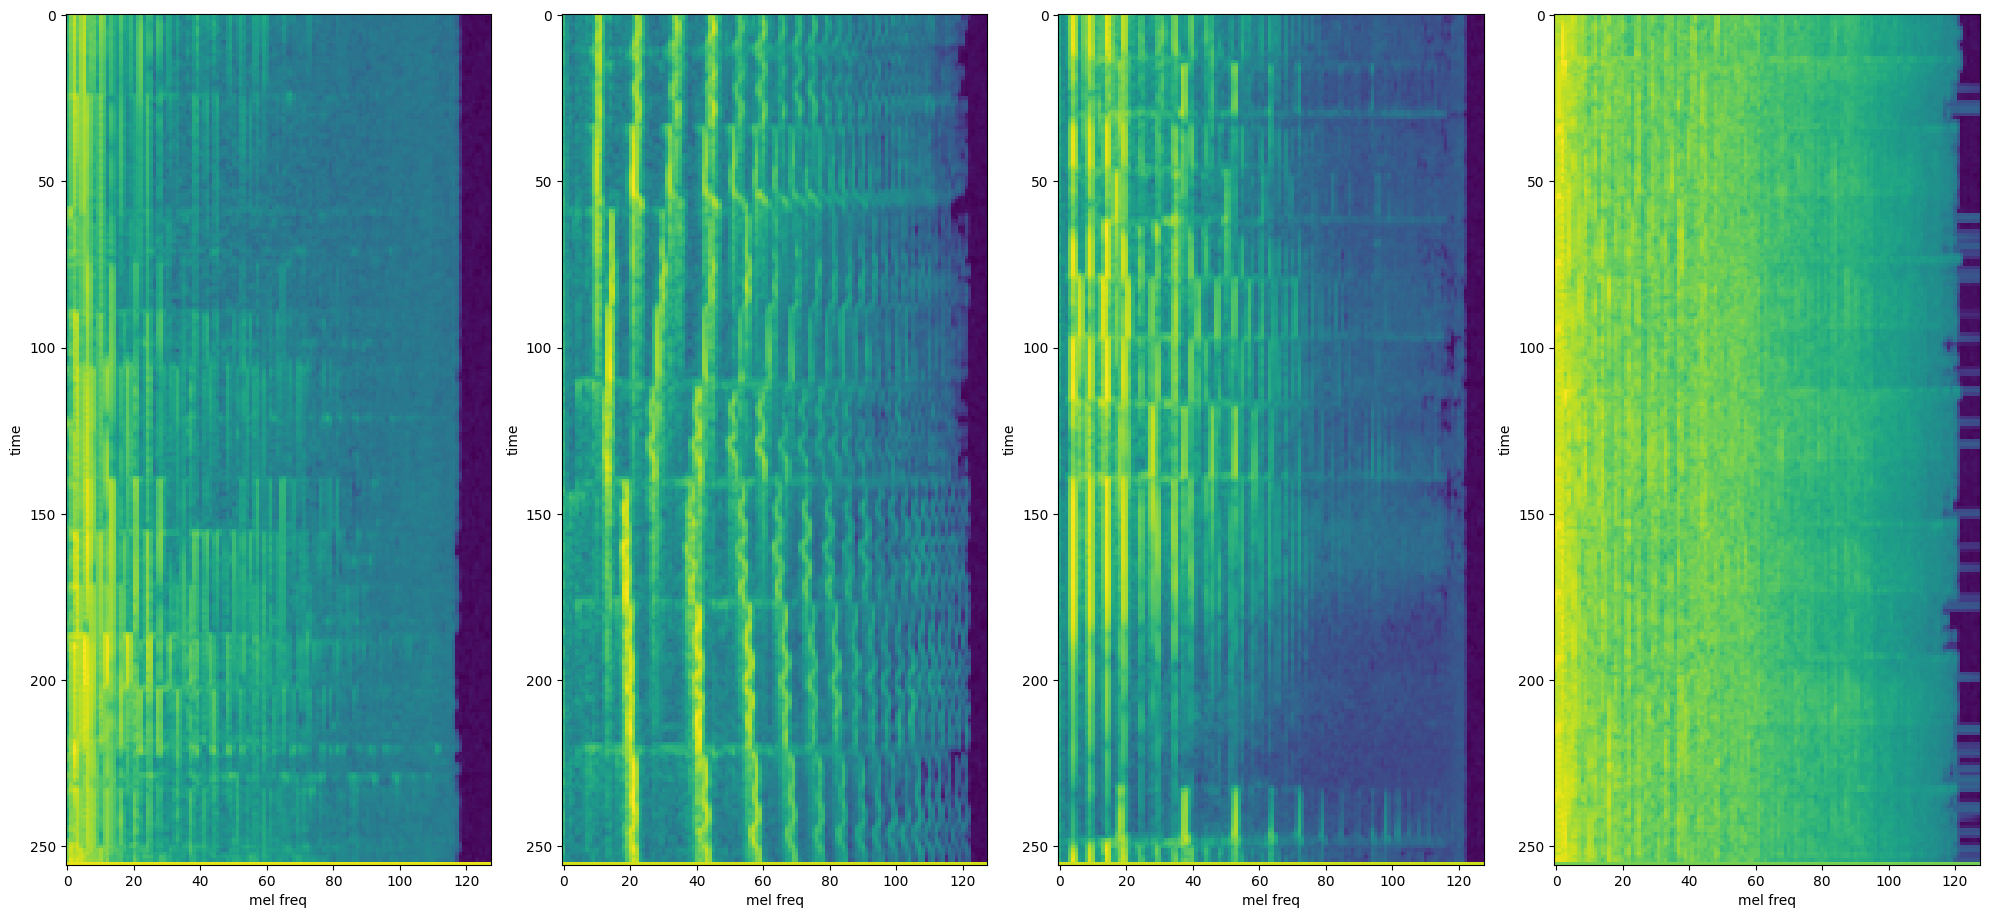

In [ ]:
import matplotlib.pyplot as plt

ex, ex_label = train_generator.__getitem__(0)
fig, axes = plt.subplots(1, 4, figsize = (20, 20))
print(ex.shape)
axes = axes.flatten()
for i in range(4):
  ax = axes[i]
  ax.imshow(tf.squeeze(np.array(ex[i]), axis = [2]), interpolation = 'none')
  ax.set_xlabel('mel freq')
  ax.set_ylabel('time')

plt.tight_layout()
plt.show()


In [ ]:
model = ResNet18()
model.build(input_shape=(256, 256, 128, 1))

model.summary()
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
with tf.device('/GPU:0'):
    # Train the model
    history = model.fit(train_generator, epochs = 50, validation_data = val_generator)



Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (256, 64, 32, 64)         3456      
                                                                 
 sequential_1 (Sequential)   (256, 64, 32, 64)         74112     
                                                                 
 sequential_2 (Sequential)   (256, 64, 32, 64)         74112     
                                                                 
 sequential_3 (Sequential)   (256, 32, 16, 128)        230784    
                                                                 
 sequential_5 (Sequential)   (256, 32, 16, 128)        295680    
                                                                 
 sequential_6 (Sequential)   (256, 16, 8, 256)         920320    
                                                                 
 sequential_8 (Sequential)   (256, 16, 8, 256)         11